In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, linalg
import healpy as hp
import emcee, tqdm, corner
import scipy.optimize

In [200]:
nside=64

In [201]:
def downsize(arr, nbig, nsmall):
    return np.sum(np.reshape(arr, (-1,int((nbig/nsmall)**2+0.1))), axis=1)

## Initialise logit probabilities

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


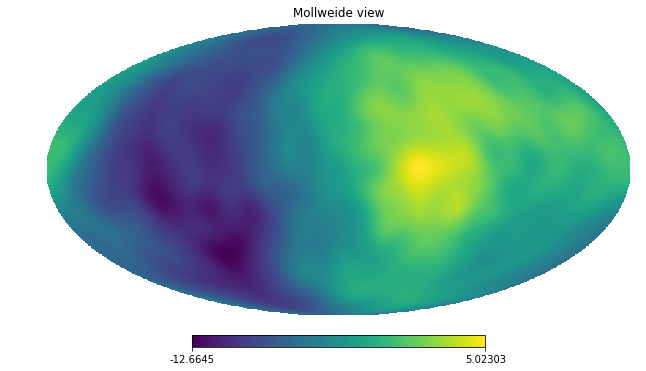

In [202]:
lmax = 20
l = hp.sphtfunc.Alm.getlm(lmax=lmax-1)[0]
scale = 10.0/(1.0+l)**2
_alm = np.random.normal(0,scale,int(lmax*(lmax+1)/2)) + 1j*np.random.normal(0,scale,int(lmax*(lmax+1)/2))
_map = hp.sphtfunc.alm2map(_alm,nside=nside)
hp.mollview(_map)

## Draw sample

In [203]:
def expit(x):
    return np.exp(x)/(1+np.exp(x))

In [204]:
sample = {}
sample['hpx'] = np.random.choice(np.arange(hp.nside2npix(nside)), size=int(1e6), replace=True)
sample['p'] = expit(_map[sample['hpx']])
sample['selected'] = (np.random.rand(len(sample['hpx'])) < sample['p']).astype(int)

## Accumulate sample in bins

In [205]:
k = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='sum').statistic
n = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='count').statistic

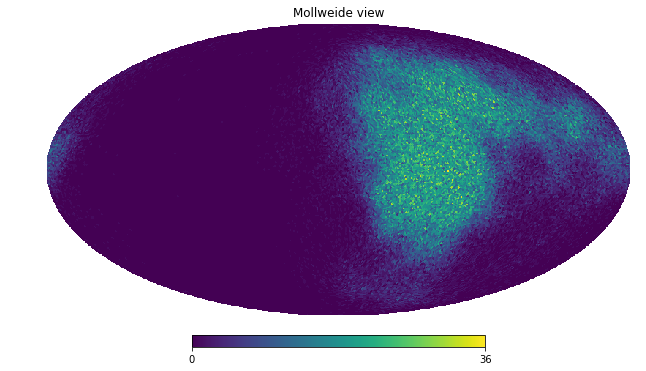

In [206]:
hp.mollview(k)

# Newton CG

## Gradient estimation
$$\frac{\partial \ln \mathcal{L}}{\partial a_{\mu\nu}} = \left( k - n\frac{\exp(x)}{1+\exp(x)}\right) Y_{\mu\nu}$$

In [207]:
lmax=20
nlm = int(lmax*(lmax+1)/2+0.01)

In [208]:
# generate sph harm grid
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)

In [213]:
def nloglike_grad(params, k, n, nlm):
    x = np.sum(params*Ylm_grid.T, axis=1)
    
    logl = np.sum( k*x - n*np.log(1+np.exp(x)) )
    
    grad_norm = k - n*np.exp(x)/(1+np.exp(x))
    grad = np.sum(grad_norm * Ylm_grid, axis=1)
    
    return -logl, -grad

In [40]:
Ylm_grid.shape

(441, 49152)

In [ ]:
nloglike_grad(np.hstack((np.real(_alm), np.imag(_alm))), k, n, nlm=nlm)

In [18]:
p0=np.random.normal(0.,1., size=2*nlm)
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', args=(k,n,nlm), jac=True)
result

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


     fun: 329613.6274079053
     jac: array([ 2.69459314e-02,  2.36654253e-02, -2.87458521e-03, -3.20015017e-02,
        1.14200431e-02,  3.24822323e-03, -7.67125670e-03,  2.45842120e-03,
       -5.92862530e-03,  4.20432891e-03, -6.40083428e-03, -1.84482806e-02,
        4.40950209e-03,  5.06013386e-03,  4.32080584e-03,  3.84830337e-03,
       -8.57445451e-05, -2.01616178e-02,  1.01788442e-02,  2.70603682e-02,
       -4.09552131e-02,  5.91838428e-02,  2.84598541e-03,  7.80459925e-03,
        3.03148702e-02, -3.41091182e-03,  7.08488750e-03, -2.23371681e-02,
        2.41564311e-02, -6.73678798e-03,  2.42400235e-02, -2.09730566e-02,
       -2.74292562e-02, -1.87180114e-02, -1.03405640e-02, -9.46824813e-03,
        1.29926725e-02,  1.66192464e-03, -1.21313718e-02,  1.01149333e-02,
       -2.77618299e-02,  2.42201410e-02, -2.00281414e-02, -5.61229881e-03,
       -5.96125623e-04, -1.19281219e-02,  7.50209504e-03,  7.27685859e-03,
       -2.07436257e-02, -3.82286611e-03,  1.77983400e-02, -3.0

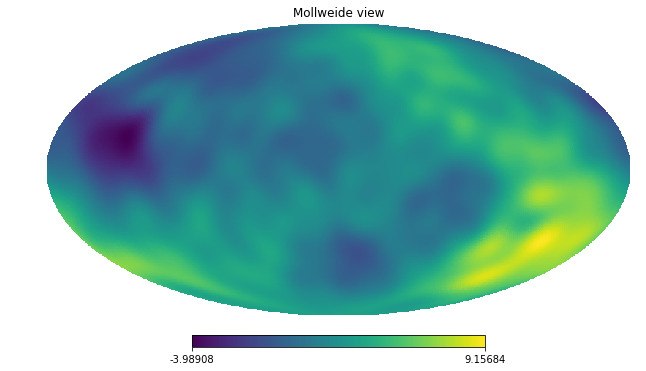

In [21]:
x = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(x)

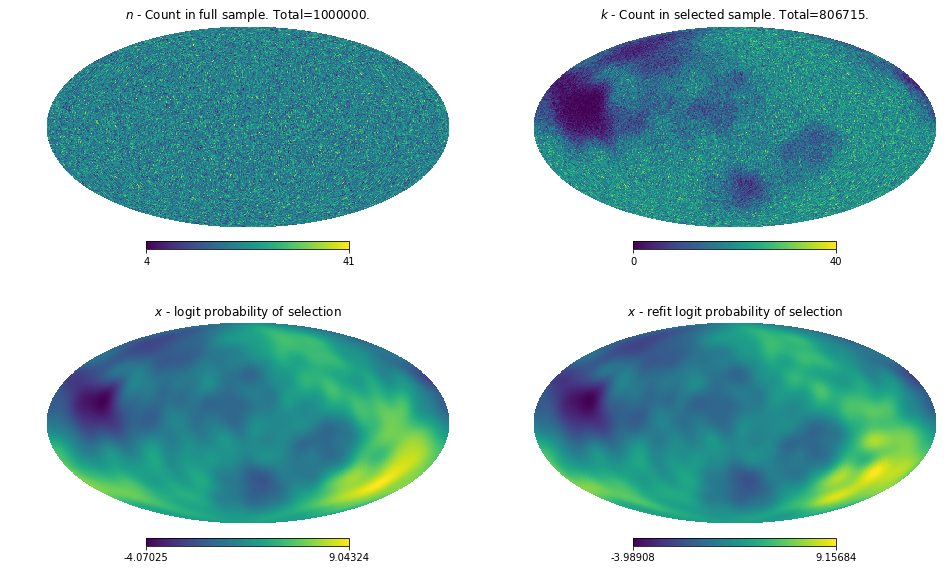

In [23]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

plt.sca(ax[0,0])
hp.mollview(n, hold=True, title=r'$n$ - Count in full sample. Total=%d.' % np.sum(n))
plt.sca(ax[0,1])
hp.mollview(k, hold=True, title=r'$k$ - Count in selected sample. Total=%d.' % np.sum(k))

plt.sca(ax[1,0])
_map = hp.sphtfunc.alm2map(_alm,nside=nside, verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - logit probability of selection')

plt.sca(ax[1,1])
_map = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - refit logit probability of selection')

#plt.savefig('figs/astsf_dummy_sphharm_lmax%d.png' % lmax, bbox='tight', dpi=200)

### Same thing with real spherical harmonics 

In [216]:
nside, lmax

(64, 20)

In [217]:
lmax=10

In [218]:
_harmonics = {}
with h5py.File('/data/asfe2/Projects/gaia_edr3/sphericalharmonics_decomposed_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        _harmonics[key] = hf[key][...]

OSError: Unable to open file (unable to open file: name = '/data/asfe2/Projects/gaia_edr3/sphericalharmonics_decomposed_nside64_lmax10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [211]:
Ylm_grid = np.zeros((_harmonics['m'].shape[0], hp.nside2npix(nside)))
real_harmonics(Ylm_grid, _harmonics['lambda'], _harmonics['azimuth'], \
                    _harmonics['m'], lmax, _harmonics['jpix'])

array([[ 2.82094792e-01,  2.82094792e-01,  2.82094792e-01, ...,
         2.82094792e-01,  2.82094792e-01,  2.82094792e-01],
       [ 8.81528289e-03,  8.81528289e-03, -8.81528289e-03, ...,
         8.81528289e-03, -8.81528289e-03, -8.81528289e-03],
       [ 4.88562749e-01,  4.88562749e-01,  4.88562749e-01, ...,
        -4.88562749e-01, -4.88562749e-01, -4.88562749e-01],
       ...,
       [ 2.17333759e-48, -1.35254305e-47,  3.86127019e-48, ...,
        -1.35254305e-47,  3.86127019e-48,  5.80289012e-48],
       [ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [215]:
%timeit nloglike_grad(p0,k,n,nlm)

112 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [214]:
p0=np.random.normal(0.,1., size=Ylm_grid.shape[0])
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', args=(k,n,nlm), jac=True)
result

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/andy/py3/lib/python3.5/site-

KeyboardInterrupt: 

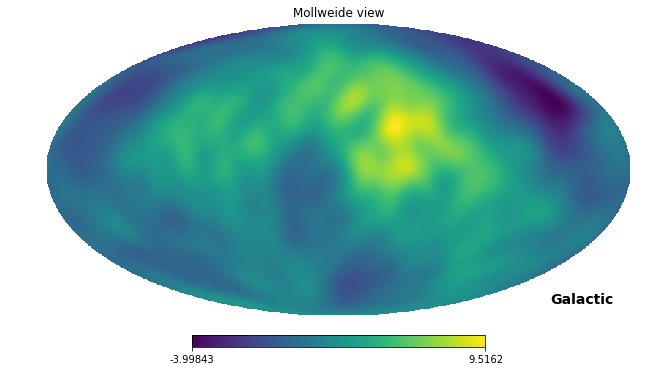

In [46]:
hp.mollview(np.sum(Ylm_grid.T * result['x'], axis=1))#, coord=['C','G'])

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

plt.sca(ax[0,0])
hp.mollview(n, hold=True, title=r'$n$ - Count in full sample. Total=%d.' % np.sum(n))
plt.sca(ax[0,1])
hp.mollview(k, hold=True, title=r'$k$ - Count in selected sample. Total=%d.' % np.sum(k))

plt.sca(ax[1,0])
_map = hp.sphtfunc.alm2map(_alm,nside=nside, verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - logit probability of selection')

plt.sca(ax[1,1])
_map = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(_map, hold=True, title=r'$x$ - refit logit probability of selection')
hp.mollview(np.sum(Ylm_grid.T * result['x'], axis=1), hold=True, 
            title=r'$x$ - refit logit probability of selection')

#plt.savefig('figs/astsf_dummy_sphharm_lmax%d.png' % lmax, bbox='tight', dpi=200)

# Speed boosted code

In [198]:
from numba import njit
import h5py

In [199]:
@njit
def sphharm_slow(alm, Ylm, n, k, npix, nmode, grad):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    grad *= 0.
    loglike = 0.

    for i in range(npix):
        x=0.
        for nu in range(nmode):
            x += Ylm[nu,i]*alm[nu]
        loglike += k[i]*x - n[i]*np.log(1+np.exp(x))
            
        for nu in range(nmode):
            grad[nu] += (k[i] - n[i]*(np.exp(x)/(1+np.exp(x))))*Ylm[nu,i]
        
    return loglike, grad

@njit
def sphharm_quick(alm, n, k, _lambda, azimuth, m, lmax, jpix, Nring, F, grad):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    F *= 0.
    grad *= 0.
    loglike = 0.
    
    nu = 0
    for _m in m:
        for j in range(Nring):
            F[_m+lmax, j] += _lambda[nu,j]*alm[nu]
        nu += 1
    
    i = 0; nu = 0
    for j in jpix:
        x=0.
        for _m in range(-lmax, lmax+1):
            x += F[_m+lmax, j]*azimuth[_m+lmax, i]
        loglike += k[i]*x - n[i]*np.log(1+np.exp(x))
        
        nu = 0
        for _m in m:
            Y = _lambda[nu,j]*azimuth[_m+lmax,i]
            grad[nu] += (k[i] - n[i]*(np.exp(x)/(1+np.exp(x))))*Y
            nu+=1
        i += 1
        
    return loglike, grad

@njit
def real_harmonics(Y, _lambda, azimuth, m, lmax, jpix):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    i = 0;
    for j in jpix:
        nu = 0
        for _m in m:
            Y[nu,i] = _lambda[nu,j]*azimuth[_m+lmax,i]
            nu+=1
        i += 1
        
    return Y

In [26]:
_harmonics = {}
with h5py.File('/data/asfe2/Projects/gaia_edr3/sphericalharmonics_decomposed_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        _harmonics[key] = hf[key][...]

In [30]:
Ylm = np.zeros((_harmonics['m'].shape[0], hp.nside2npix(nside)))
real_harmonics(Ylm, _harmonics['lambda'], _harmonics['azimuth'], \
                    _harmonics['m'], lmax, _harmonics['jpix'])

array([[ 2.82094792e-01,  2.82094792e-01,  2.82094792e-01, ...,
         2.82094792e-01,  2.82094792e-01,  2.82094792e-01],
       [ 4.40764145e-03,  4.40764145e-03, -4.40764145e-03, ...,
         4.40764145e-03, -4.40764145e-03, -4.40764145e-03],
       [ 4.88562749e-01,  4.88562749e-01,  4.88562749e-01, ...,
        -4.88562749e-01, -4.88562749e-01, -4.88562749e-01],
       ...,
       [ 1.08666879e-48, -6.76271525e-48,  1.93063510e-48, ...,
        -6.76271525e-48,  1.93063510e-48,  2.90144506e-48],
       [-4.13452195e-36,  4.13452195e-36,  4.13452195e-36, ...,
        -4.13452195e-36, -4.13452195e-36,  4.13452195e-36],
       [-1.17953602e-38, -1.17953602e-38, -1.17953602e-38, ...,
        -1.17953602e-38, -1.17953602e-38, -1.17953602e-38]])

In [33]:
grad = np.zeros(_harmonics['m'].shape[0])

In [34]:
p0=np.random.normal(0.,1., size=_harmonics['m'].shape[0])
result = scipy.optimize.minimize(sphharm_slow, p0, method='Newton-CG', 
                                 options={'disp':True,'xtol':1e-8},
                    args=(Ylm, n, k, Ylm.shape[1], Ylm.shape[0], grad), jac=True)
#result

Optimization terminated successfully.
         Current function value: -2526847.611912
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 4
         Hessian evaluations: 0


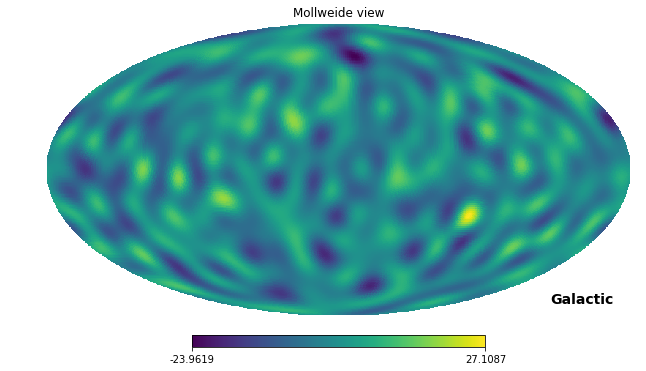

In [35]:
hp.mollview(np.sum(Ylm.T * result['x'], axis=1), coord=['C','G'])

# Converting healpy spherical harmonics

In [5]:
lmax=20; nside=1

Npix = hp.nside2npix(nside)
Nmodes = int((lmax+1)**2)
Nmodes_healpy = int((lmax+1)*(lmax+2)/2)

Ylm = np.zeros((Nmodes,Npix))

In [115]:
# Form the l's and m's
l = np.concatenate([np.repeat(_l,2*_l+1) for _l in range(lmax+1)]).astype(np.int)
m = np.concatenate([np.arange(-_l,_l+1e-9) for _l in range(lmax+1)]).astype(np.int)
l_hp, m_hp = hp.sphtfunc.Alm.getlm(lmax)

In [90]:
alm_hp[ii] = 1.+0.j
map_hp = (1.+0.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii] = 0.+1.j
map_hp += (0.-1.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
map_hp/np.exp(1.j*1.*phi)

array([-7.67764777e-01-7.85046229e-17j, -7.67764777e-01-7.85046229e-17j,
       -7.67764777e-01-3.92523115e-16j, -7.67764777e-01-1.57009246e-16j,
       -9.46098930e-17+0.00000000e+00j, -9.46098930e-17-5.79318513e-33j,
       -9.46098930e-17-1.15863703e-32j, -9.46098930e-17-1.73795554e-32j,
        7.67764777e-01+7.85046229e-17j,  7.67764777e-01+7.85046229e-17j,
        7.67764777e-01+3.92523115e-16j,  7.67764777e-01+1.57009246e-16j])

In [113]:
ii=2
alm_hp = np.zeros(Nmodes_healpy)*(0.+0.j)
alm_hp[ii] = 1.+0.j
map_hp = (1.+0.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii] = 0.+1.j
map_hp += (0.-1.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
map_hp /= np.exp(1.j*m_hp[ii]*phi)


map_sc = scipy.special.sph_harm(m_hp[ii], l_hp[ii], phi, theta)/np.exp(1.j*m_hp[ii]*phi)

print(m_hp[ii], l_hp[ii])
print(np.vstack((map_hp, map_sc)))

0 2
[[ 0.10513052+0.j  0.10513052+0.j  0.10513052+0.j  0.10513052+0.j
  -0.31539157+0.j -0.31539157+0.j -0.31539157+0.j -0.31539157+0.j
   0.10513052+0.j  0.10513052+0.j  0.10513052+0.j  0.10513052+0.j]
 [ 0.10513052+0.j  0.10513052+0.j  0.10513052+0.j  0.10513052+0.j
  -0.31539157+0.j -0.31539157+0.j -0.31539157+0.j -0.31539157+0.j
   0.10513052+0.j  0.10513052+0.j  0.10513052+0.j  0.10513052+0.j]]


In [179]:
ii=11
ii_hp = hp.sphtfunc.Alm.getidx(lmax, l[ii], np.abs(m[ii]))
alm_hp = np.zeros(Nmodes_healpy)*(0.+0.j)
alm_hp[ii_hp] = 1.+0.j
map_hp = (1.+0.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii_hp] = 0.+1.j
map_hp += (0.-1.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii_hp] = 0.+0.j
map_hp /= np.exp(1.j*np.abs(m[ii])*phi)

map_sc = scipy.special.sph_harm(m[ii], l[ii], phi, theta)/np.exp(1.j*m[ii]*phi)
if np.abs(m[ii])>0: map_sc*=2
if m[ii]<0: map_sc*=(-1.)**m[ii]

print(m[ii], l[ii])
print(np.vstack((map_hp, map_sc)))

-1 3
[[-0.58882826+3.92523115e-17j -0.58882826+3.92523115e-17j
  -0.58882826-2.35513869e-16j -0.58882826-3.92523115e-17j
   0.64636037+0.00000000e+00j  0.64636037+3.95781578e-17j
   0.64636037+7.91563156e-17j  0.64636037+1.18734473e-16j
  -0.58882826+3.92523115e-17j -0.58882826+3.92523115e-17j
  -0.58882826-2.35513869e-16j -0.58882826-3.92523115e-17j]
 [-0.58882826-3.92523115e-17j -0.58882826-3.92523115e-17j
  -0.58882826+0.00000000e+00j -0.58882826-3.92523115e-17j
   0.64636037-0.00000000e+00j  0.64636037+0.00000000e+00j
   0.64636037+0.00000000e+00j  0.64636037-0.00000000e+00j
  -0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j
  -0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j]]


In [184]:
ii=11
ii_hp = hp.sphtfunc.Alm.getidx(lmax, l[ii], np.abs(m[ii]))
alm_hp = np.zeros(Nmodes_healpy)*(0.+0.j)
alm_hp[ii_hp] = 1.+0.j
map_hp = (1.+0.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii_hp] = 0.+1.j
map_hp += (0.-1.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii_hp] = 0.+0.j
map_hp /= np.exp(1.j*np.abs(m[ii])*phi)

map_sc = scipy.special.sph_harm(m[ii], l[ii], phi*0., theta)
if np.abs(m[ii])>0: map_sc*=2
if m[ii]<0: map_sc*=(-1.)**m[ii]

print(m[ii], l[ii])
print(np.vstack((map_hp, map_sc)))

-1 3
[[-0.58882826+3.92523115e-17j -0.58882826+3.92523115e-17j
  -0.58882826-2.35513869e-16j -0.58882826-3.92523115e-17j
   0.64636037+0.00000000e+00j  0.64636037+3.95781578e-17j
   0.64636037+7.91563156e-17j  0.64636037+1.18734473e-16j
  -0.58882826+3.92523115e-17j -0.58882826+3.92523115e-17j
  -0.58882826-2.35513869e-16j -0.58882826-3.92523115e-17j]
 [-0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j
  -0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j
   0.64636037-0.00000000e+00j  0.64636037-0.00000000e+00j
   0.64636037-0.00000000e+00j  0.64636037-0.00000000e+00j
  -0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j
  -0.58882826+0.00000000e+00j -0.58882826+0.00000000e+00j]]


In [87]:
ii=22
alm_hp = np.zeros(Nmodes_healpy)*(0.+0.j)
alm_hp[ii] = 1.+0.j
map_hp = (1.+0.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
alm_hp[ii] = 0.+1.j
map_hp += (0.-1.j)*hp.sphtfunc.alm2map(alm_hp,nside=nside, verbose=False)
map_hp /= np.exp(1.j*m_hp[ii]*phi)


map_sc = scipy.special.sph_harm(m_hp[ii], l_hp[ii], phi*0., theta)

(m_hp[ii], l_hp[ii]), map_hp, map_sc

((1, 6),
 array([-7.67764777e-01-7.85046229e-17j, -7.67764777e-01-7.85046229e-17j,
        -7.67764777e-01-3.92523115e-16j, -7.67764777e-01-1.57009246e-16j,
        -9.46098930e-17+0.00000000e+00j, -9.46098930e-17-5.79318513e-33j,
        -9.46098930e-17-1.15863703e-32j, -9.46098930e-17-1.73795554e-32j,
         7.67764777e-01+7.85046229e-17j,  7.67764777e-01+7.85046229e-17j,
         7.67764777e-01+3.92523115e-16j,  7.67764777e-01+1.57009246e-16j]),
 array([ 3.71514878e-01+0.j,  3.71514878e-01+0.j,  3.71514878e-01+0.j,
         3.71514878e-01+0.j, -8.00031703e-17+0.j, -8.00031703e-17+0.j,
        -8.00031703e-17+0.j, -8.00031703e-17+0.j, -3.71514878e-01+0.j,
        -3.71514878e-01+0.j, -3.71514878e-01+0.j, -3.71514878e-01+0.j]))

In [80]:
np.sqrt(13/(2*np.pi)) * 3.715

5.3436814400892905

In [69]:
np.real( scipy.special.sph_harm(m[ii], l[ii], phi, theta) )

array([0.28209479, 0.28209479, 0.28209479, 0.28209479, 0.28209479,
       0.28209479, 0.28209479, 0.28209479, 0.28209479, 0.28209479,
       0.28209479, 0.28209479])

In [ ]:
lmax = 20
l = hp.sphtfunc.Alm.getlm(lmax=lmax-1)[0]
scale = 10.0/(1.0+l)**2
_alm = np.random.normal(0,scale,int(lmax*(lmax+1)/2)) + 1j*np.random.normal(0,scale,int(lmax*(lmax+1)/2))
_map = hp.sphtfunc.alm2map(_alm,nside=nside)
hp.mollview(_map)

In [194]:
# Ring idxs of pixels with phi=0
theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
theta_ring, idx, jpix = np.unique(theta, return_index=True, return_inverse=True)